In [2]:
import pandas as pd  
import collections
import numpy as np
from textblob import TextBlob # pip install -U textblob, python -m textblob.download_corpora
from textblob.classifiers import NaiveBayesClassifier
import nltk # pip install nltk, python -m textblob.download_corpora
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline # pip install -q transformers
import matplotlib.pyplot as plt

# making dataframe
df = pd.read_csv("data/sentiment140_with_location.csv", names=['target','id','date','flag','user','text', 'location'])  

df

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,target,id,date,flag,user,text,location
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",China
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Dominican Republic
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Germany
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Brazil
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Argentina
...,...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,Japan
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,Spain
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,Nigeria
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,Argentina


In [3]:
# split dataset
shuffled = df.sample(frac = 1)
result = np.array_split(shuffled, 8)
split_df = result[0]
split_df

c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,target,id,date,flag,user,text,location
1320922,4,2014633576,Wed Jun 03 02:10:35 PDT 2009,NO_QUERY,PaulDJohnston,@tunatheday I know the feeling,France
327407,0,2009596902,Tue Jun 02 15:57:41 PDT 2009,NO_QUERY,mmevnz,So sick... Probably shouldn't have gone to wor...,Indonesia
654709,0,2239566500,Fri Jun 19 08:42:00 PDT 2009,NO_QUERY,Smokeys_Friend,It's way too early for me to be awake!,Italy
744349,0,2267109209,Sun Jun 21 09:38:27 PDT 2009,NO_QUERY,werokthatswhy,@ErictheAzn Me 2 Erci me 2 .Sorry for the last...,Peru
1032845,4,1936027065,Wed May 27 07:19:21 PDT 2009,NO_QUERY,ashutosh_g,@jungleegirl I prefer twinnings earl grey not...,Colombia
...,...,...,...,...,...,...,...
1521660,4,2176349578,Mon Jun 15 03:37:52 PDT 2009,NO_QUERY,tracys,Really glad that I opted for an early 5 AM sta...,Germany
632945,0,2232840075,Thu Jun 18 20:28:07 PDT 2009,NO_QUERY,filencia,@patpatnanda huahhh I'm solliee. I didn't mean...,Cuba
834496,4,1557980659,Sun Apr 19 06:49:12 PDT 2009,NO_QUERY,camdenchild,parkkk with brad then reppin see hil park with...,Nigeria
825039,4,1556382888,Sat Apr 18 22:37:30 PDT 2009,NO_QUERY,ensredshirt,@robynmcintyre I was talking to a coworker tod...,Cuba


In [6]:
# tweets_by_location = collections.defaultdict(list)
# sentiment_sum = 0
# for row in df.iterrows():
#     sentiment = row[1][0]
#     text = row[1][5]
#     location = row[1][6]
#     sentiment_sum += sentiment
#     tweets_by_location[location].append(text)
# # print(tweets_by_location)
# print("average sentiment: ", sentiment_sum/df.size)

    

In [4]:
target_counts = collections.Counter(result[0]['target'])
location_counts = collections.Counter(result[0]['location'])
print("target counts: ", target_counts)
print("location_counts: ", location_counts)

target counts:  Counter({4: 100094, 0: 99906})
location_counts:  Counter({'Germany': 6166, 'Cuba': 6159, 'Mexico': 6143, 'USA': 6141, 'Nigeria': 6139, 'Peru': 6137, 'India': 6137, 'Kenya': 6124, 'Brazil': 6106, 'South Africa': 6094, 'Japan': 6094, 'Italy': 6081, 'Tanzania': 6080, 'Egypt': 6075, 'Ethiopia': 6059, 'Indonesia': 6058, 'China': 6052, 'France': 6050, 'Australia': 6048, 'Russia': 6045, 'UK': 6042, 'Jamaica': 6035, 'Chile': 6034, 'South Korea': 6033, 'New Zealand': 6024, 'Colombia': 6000, 'Spain': 5992, 'Argentina': 5991, 'Thailand': 5991, 'Dominican Republic': 5982, 'Antarctica': 5975, 'Ecuador': 5960, 'Canada': 5953})


In [5]:
def locationSentiment(data, location):
    """
    input: location is the input location of interest
    output: the average sentiment of the tweets for a location
    """
    # go through the dataframe filtered by location
    # get the average sentiment of the tweets in that location by getting sum and dividing by number of rows
    location_data = data[data["location"] == location]
    total_sentiment_value = sum(list(location_data["target"]))
    return total_sentiment_value/len(location_data)

def getLocationTweetsWithSentiment(data, location):
    tweets_with_sentiment = []
    location_data = data[data["location"] == location]
    for row in location_data.iterrows():
        sentiment = row[1]['target']
        text = row[1]['text']
        sentiment_for_classifier = ""
        if sentiment == 0:
            # negative
            sentiment_for_classifier = "neg"
        elif sentiment == 4:
            # positive
            sentiment_for_classifier = "pos"
        tweets_with_sentiment.append((text,sentiment_for_classifier))
    return tweets_with_sentiment

# print(locationSentiment(result[0], "China"))
tweets = getLocationTweetsWithSentiment(result[0], "China")
print(tweets)


[('in times like these, i wish i could be....... someone who is in the beach or in chicago or in nyc or in las vegas or cancun or london  ha', 'neg'), ("@lashaunda and graduation party for me! Haha if only i didn't have class that week   boo lol", 'neg'), ("Wrote a new poem but I can't think of a title.....who wanna read it and give me some ideas? ", 'pos'), ("@BobGlauber  You've got the hang of it now Bob.  Enjoy your twittering.   Here's a good link 4 U http://tinyurl.com/c5v5z3", 'pos'), ("@MJihad but i'd love the code!  thanks!", 'pos'), ('feeling really sick now!! tooo full, my moms roast dinners are killing me ', 'neg'), ("Off for a trek in the sunshine  It's sooooooo Nice x", 'pos'), ('@berriesngum Hope you liked the cupcakes, sweetz! ', 'pos'), ('Heyy.thnxx.or.inviting.me.to.ur.party.rob.ill.be.down.there.on.june.24th.ill.miss.u.when.u.go.to.italy....   &lt;333333333 txt.me.hon!!! ', 'neg'), ('@Salteh Happy Birthday, mate! Have a good one! ', 'pos'), ("Okay, now I'm in a bad mo

In [6]:
# find average sentiment for each location and store in location_scores
location_scores = {}

for (location, count) in location_counts.items():
    score = locationSentiment(result[0], location)
    location_scores[location] = score

# code sourced from https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
sorted_location_scores = {k: v for k, v in sorted(location_scores.items(), key=lambda item: item[1])}
sorted_location_scores

{'Ethiopia': 1.9587390658524508,
 'Jamaica': 1.9605633802816902,
 'Spain': 1.965954606141522,
 'USA': 1.9703631330402214,
 'Canada': 1.9781622711238032,
 'Brazil': 1.981002292826728,
 'Italy': 1.9819108699227101,
 'Thailand': 1.9829744616925389,
 'Peru': 1.9846830699038618,
 'Mexico': 1.9846980302783657,
 'Egypt': 1.9871604938271605,
 'South Korea': 1.989723189126471,
 'Japan': 1.9908106334099114,
 'Tanzania': 1.9921052631578948,
 'China': 1.992729676140119,
 'Colombia': 1.9933333333333334,
 'Cuba': 1.9938301672349408,
 'India': 1.9957634023138342,
 'UK': 1.9966898378020523,
 'France': 2.0,
 'Russia': 2.0009925558312656,
 'Chile': 2.0053032814053697,
 'Dominican Republic': 2.0053493814777665,
 'Ecuador': 2.0134228187919465,
 'Kenya': 2.020901371652515,
 'Germany': 2.021407719753487,
 'South Africa': 2.029537249753856,
 'Indonesia': 2.0343347639484977,
 'Australia': 2.0350529100529102,
 'New Zealand': 2.0358565737051793,
 'Nigeria': 2.046587392083401,
 'Argentina': 2.059756301118344,
 '

In [7]:
# drop unnecessary columns
split_df = split_df.drop(['id', 'date', 'flag', 'user'], axis=1)

split_df

,target,text,location
1320922,4,@tunatheday I know the feeling,France
327407,0,So sick... Probably shouldn't have gone to wor...,Indonesia
654709,0,It's way too early for me to be awake!,Italy
744349,0,@ErictheAzn Me 2 Erci me 2 .Sorry for the last...,Peru
1032845,4,@jungleegirl I prefer twinnings earl grey not...,Colombia
...,...,...,...
1521660,4,Really glad that I opted for an early 5 AM sta...,Germany
632945,0,@patpatnanda huahhh I'm solliee. I didn't mean...,Cuba
834496,4,parkkk with brad then reppin see hil park with...,Nigeria
825039,4,@robynmcintyre I was talking to a coworker tod...,Cuba


In [8]:
# Naive Bayes Classifier
dataset = getLocationTweetsWithSentiment(result[0], "USA")
train = dataset[:int(0.8*len(dataset))] # change this so that its actually a train test split 
test = dataset[int(0.8*len(dataset)):]
cl = NaiveBayesClassifier(train) # train needs tuples of text and pos/neg
correct = 0
for text, sentiment in test:
    pred = cl.classify(text)
    correct += (pred == sentiment)
print(correct/len(test))


0.7160292921074044


In [10]:
# nltk sentiment intensity analyzer model
# 51% accuracy

sia = SentimentIntensityAnalyzer()
correct = 0
neu_count = 0
for text, sentiment in test:
    sia_pred = sia.polarity_scores(text)
    if sia_pred["compound"] < 0:
        pred = "neg"
    elif sia_pred["compound"] > 0:
        pred = "pos"
    else:
        pred = "neu"
        neu_count += 1
    correct += (pred == sentiment)

print("accuracy:", correct/len(test))
print("neu %:", neu_count/len(test))


accuracy: 0.4890154597233523
neu %: 0.2872253864930838


In [11]:
# this takes a while to run (took 3 min for me)

# hugging face transformer model
# 50% accuracy
specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

correct = 0
data = [text for text, sentiment in test]

results = specific_model(data)

print(results)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'NEG', 'score': 0.9757653474807739}, {'label': 'NEG', 'score': 0.7707419395446777}, {'label': 'NEG', 'score': 0.5858238339424133}, {'label': 'POS', 'score': 0.7250548601150513}, {'label': 'NEG', 'score': 0.92391037940979}, {'label': 'NEG', 'score': 0.8524266481399536}, {'label': 'POS', 'score': 0.9872287511825562}, {'label': 'POS', 'score': 0.9917553663253784}, {'label': 'NEG', 'score': 0.9730477929115295}, {'label': 'POS', 'score': 0.9643010497093201}, {'label': 'POS', 'score': 0.9924058318138123}, {'label': 'POS', 'score': 0.992975115776062}, {'label': 'NEU', 'score': 0.8420159220695496}, {'label': 'NEU', 'score': 0.7305477261543274}, {'label': 'POS', 'score': 0.977120041847229}, {'label': 'NEG', 'score': 0.4977229833602905}, {'label': 'NEG', 'score': 0.9709560871124268}, {'label': 'NEU', 'score': 0.8865233063697815}, {'label': 'POS', 'score': 0.9835102558135986}, {'label': 'NEU', 'score': 0.9652674794197083}, {'label': 'NEG', 'score': 0.9553222060203552}, {'label': 'NEU',

In [12]:
# calculations for above model
correct = 0
neu_count = 0
for i in range(len(results)):
    label = results[i]['label'].lower()
    sentiment = test[i][1]
    if label == 'neu':
        neu_count += 1
    correct += (pred == sentiment)

print("accuracy:", correct/len(test))
print("neu %:", neu_count/len(test))

accuracy: 0.4792514239218877
neu %: 0.31082180634662326


things to note about dataset:
- no "0" or "neutral" labels



data clean up:

- remove links from tweets, something like:
tweets = [t.replace("://", "//") for t in nltk.corpus.twitter_samples.strings()]

- remove tweets that don't have a location


TODO: 
* Location sentiment scores
* bar graphs for sentiment by location


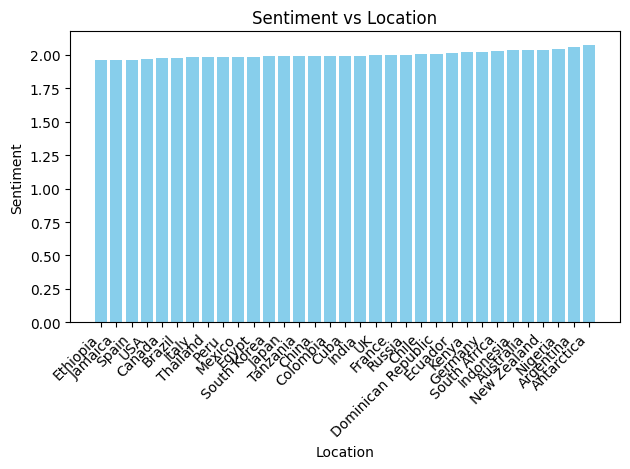

In [15]:
def plot_bar_graph(locations_with_sentiments):
    """
    input: locations with sentiments is a dictionary with the keys being the locations and the values is the sentiment
    """
    locations_list = (list(locations_with_sentiments.keys()))
    # sentiment_list = list(locations_with_sentiments.values())
    sentiment_list = list(locations_with_sentiments.values())

    # Plotting
    plt.bar(locations_list, sentiment_list, color='skyblue')
    plt.xlabel('Location')
    plt.ylabel('Sentiment')
    plt.title('Sentiment vs Location')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()


# sorted_location_scores

plot_bar_graph(sorted_location_scores)

In [16]:
# only done for naive bayes so far
def averageSentimentByLocation(location):
    dataset = getLocationTweetsWithSentiment(result[0], location)
    train = dataset[:int(0.8*len(dataset))] # change this so that its actually a train test split 
    test = dataset[int(0.8*len(dataset)):]
    # naive bayes
    naive_bayes = NaiveBayesClassifier(train)
    total_sentiment = 0
    true_sentiment = 0
    for text, sentiment in test:
        pred = naive_bayes.classify(text)
        if sentiment == "pos":
            true_sentiment += 4
        if pred == "pos":
            total_sentiment += 4
        if pred == "neu":
            total_sentiment += 2
        # negative is still just value 0
    average_sentiment = total_sentiment/len(test)
    average_true = true_sentiment/len(test)
    print("average true sentiment ", average_true)
    return average_sentiment
    
# averageSentimentByLocation('China')

In [ ]:
import nltk
nltk.download(["names", "stopwords", "state_union", "twitter_samples", "movie_reviews", "averaged_perceptron_tagger", "vader_lexicon","punkt",])

[nltk_data] <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED]
[nltk_data]     certificate verify failed: unable to get local issuer
[nltk_data]     certificate (_ssl.c:997)>


False

In [17]:
# SentimentIntensityAnalyzer (pre-trained)
def averageSentimentByLocation_sia(location):
    dataset = getLocationTweetsWithSentiment(result[0], location)
    test = dataset[int(0.8*len(dataset)):]
    sia = SentimentIntensityAnalyzer()
    total_sentiment = 0
    # using test so we can compare scores across models
    for text, _ in test:
        sia_pred = sia.polarity_scores(text)
        if sia_pred["compound"] > 0:
            total_sentiment += 4
        elif sia_pred["compound"] == 0:
            total_sentiment += 2
    average_sentiment = total_sentiment/len(dataset)
    return average_sentiment

# averageSentimentByLocation_sia('China')
    

In [18]:
# hugging face transformer model (pre-trained)
def averageSentimentByLocation_hf(location):
    dataset = getLocationTweetsWithSentiment(result[0], location)
    specific_model = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")
    # note: model can only take 204 or 128 items in dataset, so only using test
    data = [text for text, sentiment in test]
    results = specific_model(data)

    print(results)
    total_sentiment = 0
    for r in results:
        label = r['label'].lower()
        if label == 'pos':
            total_sentiment += 4
        if label == 'neu':
            total_sentiment += 2
    average_sentiment = total_sentiment/len(dataset)
    return average_sentiment

# averageSentimentByLocation_hf('China')

average true sentiment  2.004954582989265


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'NEG', 'score': 0.9757653474807739}, {'label': 'NEG', 'score': 0.7707419395446777}, {'label': 'NEG', 'score': 0.5858238339424133}, {'label': 'POS', 'score': 0.7250548601150513}, {'label': 'NEG', 'score': 0.92391037940979}, {'label': 'NEG', 'score': 0.8524266481399536}, {'label': 'POS', 'score': 0.9872287511825562}, {'label': 'POS', 'score': 0.9917553663253784}, {'label': 'NEG', 'score': 0.9730477929115295}, {'label': 'POS', 'score': 0.9643010497093201}, {'label': 'POS', 'score': 0.9924058318138123}, {'label': 'POS', 'score': 0.992975115776062}, {'label': 'NEU', 'score': 0.8420159220695496}, {'label': 'NEU', 'score': 0.7305477261543274}, {'label': 'POS', 'score': 0.977120041847229}, {'label': 'NEG', 'score': 0.4977229833602905}, {'label': 'NEG', 'score': 0.9709560871124268}, {'label': 'NEU', 'score': 0.8865233063697815}, {'label': 'POS', 'score': 0.9835102558135986}, {'label': 'NEU', 'score': 0.9652674794197083}, {'label': 'NEG', 'score': 0.9553222060203552}, {'label': 'NEU',

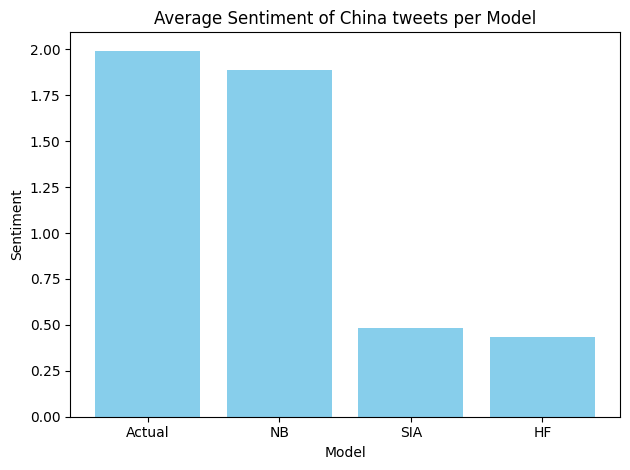

In [19]:
def plotBarGraph_locSent(location, original_sentiments):
    """
    input: location of interest
    """
    true_sentiment = original_sentiments[location]
    nb_sentiment = averageSentimentByLocation(location)
    sia_sentiment = averageSentimentByLocation_sia(location)
    hf_sentiment = averageSentimentByLocation_hf(location)

    model_names = ["Actual", "NB", "SIA", "HF"] # add this in "Sentiment Intensity Analyzer"
    sentiment_values = [true_sentiment, nb_sentiment, sia_sentiment, hf_sentiment] # add this in sia_sentiment 
    # Plotting
    plt.bar(model_names, sentiment_values, color='skyblue')
    plt.xlabel('Model')
    plt.ylabel('Sentiment')
    plt.title(f'Average Sentiment of {location} tweets per Model')
    # plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

plotBarGraph_locSent("China", sorted_location_scores)

average true sentiment  2.031905961376994


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'NEG', 'score': 0.9757653474807739}, {'label': 'NEG', 'score': 0.7707419395446777}, {'label': 'NEG', 'score': 0.5858238339424133}, {'label': 'POS', 'score': 0.7250548601150513}, {'label': 'NEG', 'score': 0.92391037940979}, {'label': 'NEG', 'score': 0.8524266481399536}, {'label': 'POS', 'score': 0.9872287511825562}, {'label': 'POS', 'score': 0.9917553663253784}, {'label': 'NEG', 'score': 0.9730477929115295}, {'label': 'POS', 'score': 0.9643010497093201}, {'label': 'POS', 'score': 0.9924058318138123}, {'label': 'POS', 'score': 0.992975115776062}, {'label': 'NEU', 'score': 0.8420159220695496}, {'label': 'NEU', 'score': 0.7305477261543274}, {'label': 'POS', 'score': 0.977120041847229}, {'label': 'NEG', 'score': 0.4977229833602905}, {'label': 'NEG', 'score': 0.9709560871124268}, {'label': 'NEU', 'score': 0.8865233063697815}, {'label': 'POS', 'score': 0.9835102558135986}, {'label': 'NEU', 'score': 0.9652674794197083}, {'label': 'NEG', 'score': 0.9553222060203552}, {'label': 'NEU',

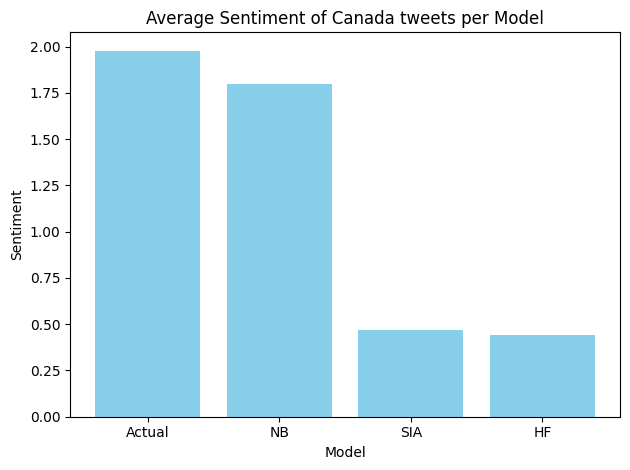

In [20]:
plotBarGraph_locSent("Canada", sorted_location_scores)

average true sentiment  1.9170056956875507


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'NEG', 'score': 0.9757653474807739}, {'label': 'NEG', 'score': 0.7707419395446777}, {'label': 'NEG', 'score': 0.5858238339424133}, {'label': 'POS', 'score': 0.7250548601150513}, {'label': 'NEG', 'score': 0.92391037940979}, {'label': 'NEG', 'score': 0.8524266481399536}, {'label': 'POS', 'score': 0.9872287511825562}, {'label': 'POS', 'score': 0.9917553663253784}, {'label': 'NEG', 'score': 0.9730477929115295}, {'label': 'POS', 'score': 0.9643010497093201}, {'label': 'POS', 'score': 0.9924058318138123}, {'label': 'POS', 'score': 0.992975115776062}, {'label': 'NEU', 'score': 0.8420159220695496}, {'label': 'NEU', 'score': 0.7305477261543274}, {'label': 'POS', 'score': 0.977120041847229}, {'label': 'NEG', 'score': 0.4977229833602905}, {'label': 'NEG', 'score': 0.9709560871124268}, {'label': 'NEU', 'score': 0.8865233063697815}, {'label': 'POS', 'score': 0.9835102558135986}, {'label': 'NEU', 'score': 0.9652674794197083}, {'label': 'NEG', 'score': 0.9553222060203552}, {'label': 'NEU',

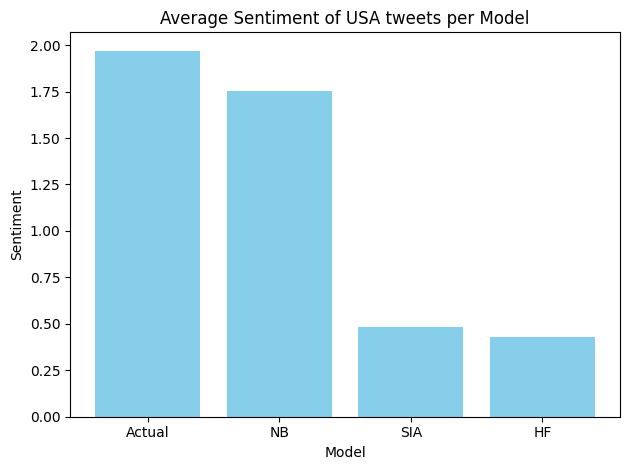

In [21]:
plotBarGraph_locSent("USA", sorted_location_scores)

average true sentiment  1.981651376146789


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


[{'label': 'NEG', 'score': 0.9757653474807739}, {'label': 'NEG', 'score': 0.7707419395446777}, {'label': 'NEG', 'score': 0.5858238339424133}, {'label': 'POS', 'score': 0.7250548601150513}, {'label': 'NEG', 'score': 0.92391037940979}, {'label': 'NEG', 'score': 0.8524266481399536}, {'label': 'POS', 'score': 0.9872287511825562}, {'label': 'POS', 'score': 0.9917553663253784}, {'label': 'NEG', 'score': 0.9730477929115295}, {'label': 'POS', 'score': 0.9643010497093201}, {'label': 'POS', 'score': 0.9924058318138123}, {'label': 'POS', 'score': 0.992975115776062}, {'label': 'NEU', 'score': 0.8420159220695496}, {'label': 'NEU', 'score': 0.7305477261543274}, {'label': 'POS', 'score': 0.977120041847229}, {'label': 'NEG', 'score': 0.4977229833602905}, {'label': 'NEG', 'score': 0.9709560871124268}, {'label': 'NEU', 'score': 0.8865233063697815}, {'label': 'POS', 'score': 0.9835102558135986}, {'label': 'NEU', 'score': 0.9652674794197083}, {'label': 'NEG', 'score': 0.9553222060203552}, {'label': 'NEU',

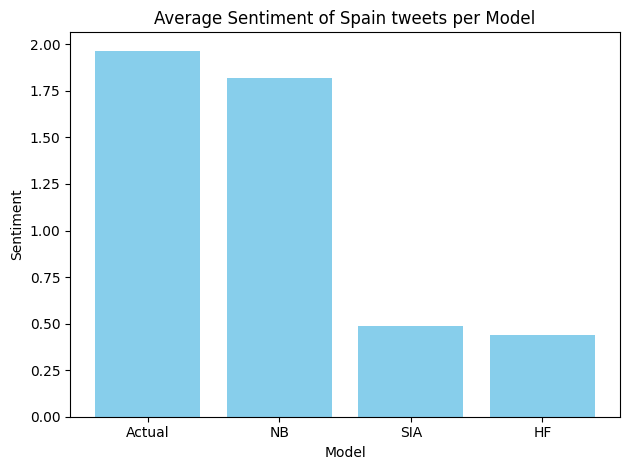

In [22]:
plotBarGraph_locSent("Spain", sorted_location_scores)

In [27]:
all_location_counts = collections.Counter(df['location'])
all_location_counts.total()

1600000